In [101]:
# For Google Colab
%pip install jaxtyping
%pip install equinox

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random as jrandom
import jax

from jax import config
config.update("jax_enable_x64", True)

from typing import Sequence, Tuple, Union, Optional
from jaxtyping import Array, ArrayLike, Float, Int, PyTree, PRNGKeyArray, ScalarLike

import equinox as eqx
import optax
import chex

import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

from dataclasses import dataclass, astuple
from functools import partial

import numpy as np

jax.enable_checks = True

jax.devices()

2023-08-31 17:56:23.081513: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-31 17:56:25.339725: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[gpu(id=0)]

# Model Definition

In [26]:
class EuropeanPayoff:
    @staticmethod
    def call(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(maturity_prices, strike_prices), 0.0)

    @staticmethod
    def put(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(strike_prices, maturity_prices), 0.0)

    @staticmethod
    def payoff(spot_path, K, payoff_fn = call):
        spot_maturity = spot_path[..., -1]
        payoff = payoff_fn(spot_maturity, K)
        return payoff


def european_payoff(spot_path, K, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[..., -1]
    payoff = payoff_fn(spot_maturity, K)
    return payoff

def european_payoff_and_deriv(spot_path, K, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[..., -1]
    # payoff = payoff_fn(spot_maturity, K)
    payoff, dpayoff = jax.value_and_grad(payoff_fn)(spot_maturity, K)
    return payoff, dpayoff

In [27]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
spot_path = jrandom.uniform(key=subkey, shape=(100,))
print(spot_path)
K = jnp.array(.5)

print(european_payoff_and_deriv(spot_path, K))

grad(partial(european_payoff, K=K))(spot_path)

# print(K)
# fn = grad(lambda spots: european_payoff(spots, K=K))
# fn = grad(partial(european_payoff, K=K))
# fn = grad(european_payoff)
# fn(spot_path, K)


[8.07676784e-01 8.16649383e-01 6.92618365e-01 7.07883981e-01
 7.45093451e-01 2.97956058e-01 3.45751930e-01 4.83979862e-01
 8.60938431e-01 5.12450007e-01 3.18727513e-01 8.54852768e-01
 8.49312532e-01 4.84552624e-01 2.74401232e-01 3.39336360e-01
 5.33114039e-01 4.85713126e-01 3.58909636e-01 4.82734975e-01
 7.68816625e-01 9.66432894e-01 9.41210526e-01 2.15436381e-01
 7.57104369e-01 7.83739145e-02 2.58091500e-02 2.80141753e-01
 8.97083744e-01 3.72210994e-01 7.31339489e-01 1.07938412e-01
 6.81433684e-01 4.58013028e-01 7.44458351e-01 6.86915710e-01
 7.33442404e-01 5.96436425e-01 2.88450505e-04 8.35000313e-02
 9.45446134e-02 5.96247853e-01 9.23704823e-01 8.01373631e-01
 9.69430195e-01 3.32758402e-02 6.33893423e-01 7.56767994e-01
 2.99471645e-01 7.40613759e-01 1.05007984e-01 6.96113797e-02
 8.35169470e-02 4.38146482e-01 7.47259834e-01 9.52343860e-01
 9.35097377e-01 4.97360182e-01 8.39483385e-01 7.04631866e-01
 1.16651419e-03 5.92934080e-01 8.87070614e-01 5.45035394e-01
 9.72520832e-01 5.907198

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],      dtype=float64)

In [46]:
@dataclass
class Range:
    min: float = 0.0
    max: float = 1.0

class HestonSoA(eqx.Module):

    n_states: int
    initial_spot_prices: Float[Array, " n"] # Array of initial spot prices
    initial_vols: Float[Array, " n"] # Array of initial volatility

    K: float = 100.0        # Strike price
    r: float = 0.05         # Risk-free rate
    T: float = 5.00         # n years until expiry, i.e. T2 - T1
    rho: float = -0.3       # Correlation of asset and volatility
    kappa: float = 2.00     # Mean-reversion rate
    theta: float = 0.09     # Long run average volatility
    xi: float = 1.00        # Volatility of volatility


    def __init__(self, key: PRNGKeyArray, n_states: int, spot_range: Range, vol_range: Range):
        self.n_states = n_states
        key, subkey = jrandom.split(key)
        self.initial_spot_prices = jrandom.uniform(subkey, shape=(n_states,), minval=spot_range.min, maxval=spot_range.max)
        # self.initial_spot_prices = jnp.ones(n_states) * 100
        key, subkey = jrandom.split(key)
        # self.initial_vols = jnp.ones(n_states) * 0.09
        self.initial_vols = jrandom.uniform(subkey, shape=(n_states, ), minval=vol_range.min, maxval=vol_range.max)

    def volatility_path(self, vol_draws):
        # n_iter = len(vol_draws)
        n_iter = vol_draws.shape[0]
        dt = self.T / n_iter

        def vol_path_iter(prev_vols_path, vol_draws):
            v_truncated = jnp.maximum(0.0, prev_vols_path)
            prev_path_contribution = prev_vols_path + self.kappa * dt * (self.theta - v_truncated)
            randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draws
            current = prev_path_contribution + randomness
            return current, current # use current both for carry and for y

        # carry, vol_path = jax.lax.scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_iter)
        carry, vol_path = jax.lax.scan(vol_path_iter, self.initial_vols, vol_draws, length=n_iter)

        # we now have iteration 1 at position 0. Place initial v0 at the end and rotate into initial slot
        vol_path = jnp.roll(vol_path.at[-1, :].set(self.initial_vols), 1, axis=0)
        return vol_path

    def spot_path(self, spot_draws: Array, vol_path: Array) -> Array:
        n_iter = spot_draws.shape[0]
        dt = self.T / n_iter

        def spot_path_iter(prev_spot_path, iter_pair):
            # print("iter pair ", iter_pair.shape)
            spot_draw = iter_pair[0]
            vol = iter_pair[1]
            v_truncated = jnp.maximum(0.0, vol)
            path_new_spot = prev_spot_path * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draw)
            return path_new_spot, path_new_spot

        # print("spot draws.shape ", spot_draws.shape)
        # print("vol path.shape ", vol_path.shape)
        iter_values = jnp.stack((spot_draws, vol_path), axis=1)
        # print("itervalues ", iter_values.shape)
        carry, spot_paths = jax.lax.scan(spot_path_iter, self.initial_spot_prices, iter_values, length=n_iter)

        # print("Spot path.shape ", spot_paths.shape)
        # spot_paths = jnp.roll(spot_paths.at[-1, :].set(self.initial_spot_prices), 1)
        spot_paths = jnp.roll(spot_paths.at[-1, :].set(self.initial_spot_prices), 1, axis=0)
        return spot_paths

    def path(self, key: PRNGKeyArray, n_intervals: int = 1000):
        mean = jnp.zeros(2)
        cov = jnp.array([[1.0, self.rho], [self.rho, 1.0]])

        correlated_samples = jrandom.multivariate_normal(key, mean, cov, shape=(n_intervals, self.n_states))
        print(correlated_samples.shape)

        vol_draws = correlated_samples[..., 0]
        spot_draws = correlated_samples[..., 1]
        print(vol_draws.shape)
        print("spot_draws ", spot_draws.shape)

        sample_mean = jnp.mean(vol_draws)
        print(sample_mean)

        vol_path = self.volatility_path(vol_draws)
        spot_path = self.spot_path(spot_draws, vol_path)
        return vol_path, spot_path
        
    def payoff(self, key: PRNGKeyArray, n_intervals: int = 1000, payoff_fn = EuropeanPayoff.call):
        vol_path, spot_path = self.path(key, n_intervals)
        jax.debug.print("initial vol {}", vol_path[0])
        jax.debug.print("initial spot value: {}", spot_path[0])
        spot_maturity = spot_path[-1, :]
        print("maturity ", spot_maturity)
        payoff = payoff_fn(spot_maturity, self.K)
        return payoff[0]
        
    def payoff_and_deriv(self, key: PRNGKeyArray, n_intervals: int = 1000, payoff_fn = EuropeanPayoff.call):
        _, spot_path = self.path(key, n_intervals)
        spot_maturity = spot_path[-1, :]
        print("maturity ", spot_maturity)
        payoff_check = payoff_fn(spot_maturity, self.K)
        # payoff, dpayoff = jax.value_and_grad(payoff_fn)(spot_maturity, self.K)
        payoff, dpayoff_fn = eqx.filter_vjp(payoff_fn, spot_maturity, self.K)

        assert(jnp.allclose(payoff_check, payoff))
        dpayoff = dpayoff_fn(jnp.ones(payoff.size))[0]
        # print("payoff ", payoff.shape)
        return payoff, dpayoff

key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
spot_range = Range(50.0, 150.0)
vol_range = Range(0.01, 0.1)
n_states = 1
hset = HestonSoA(key, n_states, spot_range, vol_range)
print("payoff and deriv: ", hset.payoff_and_deriv)

def test(h: HestonSoA):
    samples = h.path(key)
    payoff_value = h.payoff(key)
    return payoff_value

res = grad(test, allow_int=True)(hset)
print("grad of test", res.initial_spot_prices)
print("", res.initial_vols)

payoff and deriv:  Partial(<function HestonSoA.payoff_and_deriv at 0x7f41eb3e68c0>, HestonSoA(
  n_states=1,
  initial_spot_prices=f64[1],
  initial_vols=f64[1],
  K=100.0,
  r=0.05,
  T=5.0,
  rho=-0.3,
  kappa=2.0,
  theta=0.09,
  xi=1.0
))
(1000, 1, 2)
(1000, 1)
spot_draws  (1000, 1)
0.03577292657026345
(1000, 1, 2)
(1000, 1)
spot_draws  (1000, 1)
0.03577292657026345
initial vol [0.02678053]
initial spot value: [100.34736212]
maturity  Traced<ConcreteArray([106.00922561], dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = Array([106.00922561], dtype=float64)
  tangent = Traced<ShapedArray(float64[1])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float64[1]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f41eb4c2380>, in_tracers=(Traced<ShapedArray(float64[1,1]):JaxprTrace(level=1/0)>,), out_tracer_refs=[<weakref at 0x7f41eb54b830; to 'JaxprTracer' at 0x7f41eb54b380>], out_avals=[ShapedArray(float64[1])], primitive=squeeze, params={'dimensions': (0,)}

In [15]:
@dataclass
class Range:
    min: float = 0.0
    max: float = 1.0

class HestonSoAParams(eqx.Module):

    n_states: int
    initial_spot_prices: Float[Array, " n"] # Array of initial spot prices
    initial_vols: Float[Array, " n"] # Array of initial volatility

    K: float = 100.0        # Strike price
    r: float = 0.05         # Risk-free rate
    T: float = 5.00         # n years until expiry, i.e. T2 - T1
    rho: float = -0.3       # Correlation of asset and volatility
    kappa: float = 2.00     # Mean-reversion rate
    theta: float = 0.09     # Long run average volatility
    xi: float = 1.00        # Volatility of volatility


    def __init__(self, key: PRNGKeyArray, n_states: int, spot_range: Range, vol_range: Range):
        self.n_states = n_states
        key, subkey = jrandom.split(key)
        self.initial_spot_prices = jrandom.uniform(subkey, shape=(n_states,), minval=spot_range.min, maxval=spot_range.max)
        # self.initial_spot_prices = jnp.ones(n_states) * 100
        key, subkey = jrandom.split(key)
        self.initial_vols = jrandom.uniform(subkey, shape=(n_states, ), minval=vol_range.min, maxval=vol_range.max)
        # self.initial_vols = jnp.ones(n_states) * 0.09
        
def volatility_path(self, vol_draws):
    # n_iter = len(vol_draws)
    n_iter = vol_draws.shape[0]
    dt = self.T / n_iter

    def vol_path_iter(prev_vols_path, vol_draws):
        v_truncated = jnp.maximum(0.0, prev_vols_path)
        prev_path_contribution = prev_vols_path + self.kappa * dt * (self.theta - v_truncated)
        randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draws
        current = prev_path_contribution + randomness
        return current, current # use current both for carry and for y

    # carry, vol_path = jax.lax.scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_iter)
    carry, vol_path = jax.lax.scan(vol_path_iter, self.initial_vols, vol_draws, length=n_iter)

    # we now have iteration 1 at position 0. Place initial v0 at the end and rotate into initial slot
    vol_path = jnp.roll(vol_path.at[-1, :].set(self.initial_vols), 1, axis=0)
    return vol_path

def spot_path_fn(self, spot_draws: Array, vol_path: Array) -> Array:
    n_iter = spot_draws.shape[0]
    dt = self.T / n_iter

    def spot_path_iter(prev_spot_path, iter_pair):
        # print("iter pair ", iter_pair.shape)
        spot_draw = iter_pair[0]
        vol = iter_pair[1]
        v_truncated = jnp.maximum(0.0, vol)
        path_new_spot = prev_spot_path * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draw)
        return path_new_spot, path_new_spot

    # print("spot draws.shape ", spot_draws.shape)
    # print("vol path.shape ", vol_path.shape)
    iter_values = jnp.stack((spot_draws, vol_path), axis=1)
    # print("itervalues ", iter_values.shape)
    carry, spot_paths = jax.lax.scan(spot_path_iter, self.initial_spot_prices, iter_values, length=n_iter)

    # print("Spot path.shape ", spot_paths.shape)
    # spot_paths = jnp.roll(spot_paths.at[-1, :].set(self.initial_spot_prices), 1)
    spot_paths = jnp.roll(spot_paths.at[-1, :].set(self.initial_spot_prices), 1, axis=0)
    return spot_paths

def path(self, key: PRNGKeyArray, n_intervals: int = 1000):
    mean = jnp.zeros(2)
    cov = jnp.array([[1.0, self.rho], [self.rho, 1.0]])

    correlated_samples = jrandom.multivariate_normal(key, mean, cov, shape=(n_intervals, self.n_states))
    print(correlated_samples.shape)

    vol_draws = correlated_samples[..., 0]
    spot_draws = correlated_samples[..., 1]
    print(vol_draws.shape)
    print("spot_draws ", spot_draws.shape)

    sample_mean = jnp.mean(vol_draws)
    print(sample_mean)

    vol_path = volatility_path(self, vol_draws)
    spot_path = spot_path_fn(self, spot_draws, vol_path)
    return vol_path, spot_path

def payoff(self, key: PRNGKeyArray, n_intervals: int = 1000, payoff_fn = EuropeanPayoff.call):
    vol_path, spot_path = path(self, key, n_intervals)
    spot_maturity = spot_path[-1, :]
    print("maturity: ", spot_maturity)
    
    payoff = payoff_fn(spot_maturity, self.K)
    print("payoff in fn", payoff.shape)
    print("ratio:  ", jnp.divide(payoff, spot_maturity))
    return payoff

key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
spot_range = Range(50.0, 150.0)
vol_range = Range(0.01, 0.1)
n_states = 10
hset = HestonSoAParams(key, n_states, spot_range, vol_range)
print("-" * 15)
print("initial spot prices: ", hset.initial_spot_prices)
print("initial vol: ", hset.initial_vols)

samples = path(hset, key)
payoffs = payoff(hset, key)
print("direct payoff calc: ", payoffs)

# payoff_, dpayoff = eqx.filter_value_and_grad(payoff, allow_int=True)(hset, key)
# print(dpayoff)
# print("initial spot prices grad ", dpayoff.initial_spot_prices)
# print("initial vol grad ", dpayoff.initial_vols)

Y_vjp, dpayoff_fn = eqx.filter_vjp(payoff, hset, key)

print("Y_vjp payoff: ", Y_vjp)

dpayoff = dpayoff_fn(jnp.ones(Y_vjp.size))[0]
print("initial spot prices grad ", dpayoff.initial_spot_prices)
print("initial vol grad ", dpayoff.initial_vols)
print("dpayoff ", dpayoff)


if 0:
    res = jax.jacrev(payoff, allow_int=True)(hset, key)
    print("d n_state: ", res.n_states)
    print("d initial_spot_prices ", res.initial_spot_prices)
    print("d initial_vols", res.initial_vols)

---------------
initial spot prices:  [ 71.23759105  67.59776184  72.92572055  87.31156436 121.30761088
 143.48740889  88.97484359 133.68901506  60.79846016 103.77466965]
initial vol:  [0.06565494 0.01397305 0.01400376 0.09173707 0.04556025 0.02251488
 0.07689682 0.09349058 0.07524755 0.06728141]
(1000, 10, 2)
(1000, 10)
spot_draws  (1000, 10)
-0.0016968514609961524
(1000, 10, 2)
(1000, 10)
spot_draws  (1000, 10)
-0.0016968514609961524
maturity:  [ 35.78182354  69.70201193 307.63492166 174.97861017  69.41527086
 105.10820315 126.0157536  129.22147422  42.82081099 136.01745421]
payoff in fn (10,)
ratio:   [0.         0.         0.67493937 0.42850158 0.         0.04859947
 0.20644842 0.22613482 0.         0.26480024]
direct payoff calc:  [  0.           0.         207.63492166  74.97861017   0.
   5.10820315  26.0157536   29.22147422   0.          36.01745421]
(1000, 10, 2)
(1000, 10)
spot_draws  (1000, 10)
-0.0016968514609961524
maturity:  Traced<ConcreteArray([ 35.78182354  69.70201193

In [107]:
payoff_

Array([  0.        ,   0.        , 207.63492166,  74.97861017,
         0.        ,   5.10820315,  26.0157536 ,  29.22147422,
         0.        ,  36.01745421], dtype=float64)

In [108]:
payoffs

Array([  0.        ,   0.        , 207.63492166,  74.97861017,
         0.        ,   5.10820315,  26.0157536 ,  29.22147422,
         0.        ,  36.01745421], dtype=float64)

In [109]:
# Price calculation of heston model on european call option
def price(key, heston: HestonSoA):
    n_multiplier = 10
    n_simulations = 10000 * n_multiplier
    n_outside_iter = 10 * n_multiplier
    n_sims_per_iter = n_simulations // n_outside_iter
    payoff_sum: float = 0.0
    key, subkey = jrandom.split(key)

    def pathwise_payoff_fn(payoff_sum, key):
        # print("Payoff sum shape", payoff_sum.shape)
        keys = jrandom.split(key, num=n_sims_per_iter)
        pathwise_payoff = vmap(heston.payoff)(keys)
        # print("pathwise payoff", pathwise_payoff.shape)

        payoff_sum_iter = jnp.sum(pathwise_payoff, axis=0)
        # print("payoff sum iter", payoff_sum_iter.shape)
        payoff_sum += payoff_sum_iter
        return payoff_sum, payoff_sum_iter

    keys = jrandom.split(subkey, num=n_outside_iter)
    payoff_sum, _ = jax.lax.scan(pathwise_payoff_fn, jnp.zeros(heston.n_states), keys, length=n_outside_iter)

    price = (payoff_sum / n_simulations) * jnp.exp(-heston.r * heston.T)
    return price[0]


In [110]:
key, subkey = jrandom.split(key)
spot_range = Range(50.0, 150.0)
vol_range = Range(0.01, 0.1)
n_states = 1
hset = HestonSoA(key=subkey, n_states=n_states, spot_range=spot_range, vol_range=vol_range)
key, subkey = jrandom.split(key)
prices = price(subkey, hset)
jax.debug.print("prices {}", prices)

(1000, 1, 2)
(1000, 1)
spot_draws  (1000, 1)
Traced<ShapedArray(float64[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float64[1000])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0
payoff  (1,)


2023-08-31 01:29:35.695529: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 45.78MiB (rounded to 48001280)requested by op 
2023-08-31 01:29:35.695716: W external/tsl/tsl/framework/bfc_allocator.cc:497] ****************************************************************************************************
2023-08-31 01:29:35.695905: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2593] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 48001208 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:       856B
              constant allocation:        80B
        maybe_live_out allocation:       824B
     preallocated temp allocation:   45.78MiB
                 total allocation:   45.78MiB
Peak buffers:
	Buffer 1:
		Size: 7.63MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/vmap(jit(_multivariate_normal))/jit(_normal)/jit(_normal_real

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 48001208 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:       856B
              constant allocation:        80B
        maybe_live_out allocation:       824B
     preallocated temp allocation:   45.78MiB
                 total allocation:   45.78MiB
Peak buffers:
	Buffer 1:
		Size: 7.63MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/vmap(jit(_multivariate_normal))/jit(_normal)/jit(_normal_real)/jit(_uniform)/threefry2x32" source_file="/tmp/ipykernel_372/2736093939.py" source_line=76
		XLA Label: custom-call
		Shape: u32[1000,2000]
		==========================

	Buffer 2:
		Size: 7.63MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/vmap(jit(_multivariate_normal))/jit(_normal)/jit(_normal_real)/jit(_uniform)/threefry2x32" source_file="/tmp/ipykernel_372/2736093939.py" source_line=76
		XLA Label: custom-call
		Shape: u32[1000,2000]
		==========================

	Buffer 3:
		Size: 7.63MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/vmap(jit(_multivariate_normal))/jit(_normal)/jit(_normal_real)/jit(_uniform)/threefry2x32" source_file="/tmp/ipykernel_372/2736093939.py" source_line=76
		XLA Label: fusion
		Shape: u32[1000,2000]
		==========================

	Buffer 4:
		Size: 7.63MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/vmap(jit(_multivariate_normal))/jit(_normal)/jit(_normal_real)/jit(_uniform)/threefry2x32" source_file="/tmp/ipykernel_372/2736093939.py" source_line=76
		XLA Label: fusion
		Shape: u32[1000,2000]
		==========================

	Buffer 5:
		Size: 7.63MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/vmap(jit(_multivariate_normal))/jit(_normal)/jit(_normal_real)/jit(_uniform)/threefry2x32" source_file="/tmp/ipykernel_372/2736093939.py" source_line=76
		XLA Label: fusion
		Shape: u32[1000,2000]
		==========================

	Buffer 6:
		Size: 7.63MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/vmap(jit(_multivariate_normal))/jit(_normal)/jit(_normal_real)/jit(_uniform)/threefry2x32" source_file="/tmp/ipykernel_372/2736093939.py" source_line=76
		XLA Label: fusion
		Shape: u32[1000,2000]
		==========================

	Buffer 7:
		Size: 800B
		Entry Parameter Subshape: u32[100,2]
		==========================

	Buffer 8:
		Size: 800B
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/tmp/ipykernel_372/544401990.py" source_line=22
		XLA Label: fusion
		Shape: f64[100,1]
		==========================

	Buffer 9:
		Size: 56B
		XLA Label: tuple
		Shape: (s64[], f64[1], f64[100,1], u32[100,2], f64[2,2], /*index=5*/f64[1], f64[1])
		==========================

	Buffer 10:
		Size: 32B
		XLA Label: tuple
		Shape: (s64[], f64[1000,1], f64[1000,1000,1], f64[1000,1000,1])
		==========================

	Buffer 11:
		Size: 32B
		XLA Label: tuple
		Shape: (s64[], f64[1000,1], f64[1000,1000,1], f64[1000,1000,2,1])
		==========================

	Buffer 12:
		Size: 32B
		Entry Parameter Subshape: f64[2,2]
		==========================

	Buffer 13:
		Size: 24B
		Operator: op_name="jit(scan)/jit(main)/while/body/vmap(jit(_multivariate_normal))/jit(cholesky)/cholesky" source_file="/tmp/ipykernel_372/1602492535.py" source_line=76
		XLA Label: custom-call
		Shape: (f64[2,2], f64[20], s32[])
		==========================

	Buffer 14:
		Size: 16B
		Operator: op_name="jit(scan)/jit(main)/while/body/jit(_threefry_split)/threefry2x32" source_file="/tmp/ipykernel_372/3976749096.py" source_line=12
		XLA Label: fusion
		Shape: (u32[1000], u32[1000])
		==========================

	Buffer 15:
		Size: 16B
		Operator: op_name="jit(scan)/jit(main)/while/body/jit(_threefry_split)/threefry2x32" source_file="/tmp/ipykernel_372/3976749096.py" source_line=12
		XLA Label: custom-call
		Shape: (u32[1000], u32[1000])
		==========================



In [ ]:

Y_vjp, dpayoff_fn = eqx.filter_vjp(price, subkey, hset)

print("payoff", Y_vjp)

dpayoff = dpayoff_fn(jnp.ones(Y_vjp.size))[0]
print("initial spot prices grad ", dpayoff.initial_spot_prices)
print("initial vol grad ", dpayoff.initial_vols)


In [100]:
grad(price, allow_int=True)(subkey, hset)

(1000, 1, 2)
(1000, 1)
spot_draws  (1000, 1)
Traced<ShapedArray(float64[])>with<BatchTrace(level=4/0)> with
  val = Traced<ShapedArray(float64[1000])>with<DynamicJaxprTrace(level=3/0)>
  batch_dim = 0
payoff  (1,)


2023-08-31 01:28:07.279121: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 45.78MiB (rounded to 48001280)requested by op 
2023-08-31 01:28:07.279311: W external/tsl/tsl/framework/bfc_allocator.cc:497] ****************************************************************************************************
2023-08-31 01:28:07.279476: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2593] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 48001208 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:       856B
              constant allocation:        80B
        maybe_live_out allocation:       824B
     preallocated temp allocation:   45.78MiB
                 total allocation:   45.78MiB
Peak buffers:
	Buffer 1:
		Size: 7.63MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/vmap(jit(_multivariate_normal))/jit(_normal)/jit(_normal_real

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 48001208 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:       856B
              constant allocation:        80B
        maybe_live_out allocation:       824B
     preallocated temp allocation:   45.78MiB
                 total allocation:   45.78MiB
Peak buffers:
	Buffer 1:
		Size: 7.63MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/vmap(jit(_multivariate_normal))/jit(_normal)/jit(_normal_real)/jit(_uniform)/threefry2x32" source_file="/tmp/ipykernel_372/2736093939.py" source_line=76
		XLA Label: custom-call
		Shape: u32[1000,2000]
		==========================

	Buffer 2:
		Size: 7.63MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/vmap(jit(_multivariate_normal))/jit(_normal)/jit(_normal_real)/jit(_uniform)/threefry2x32" source_file="/tmp/ipykernel_372/2736093939.py" source_line=76
		XLA Label: custom-call
		Shape: u32[1000,2000]
		==========================

	Buffer 3:
		Size: 7.63MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/vmap(jit(_multivariate_normal))/jit(_normal)/jit(_normal_real)/jit(_uniform)/threefry2x32" source_file="/tmp/ipykernel_372/2736093939.py" source_line=76
		XLA Label: fusion
		Shape: u32[1000,2000]
		==========================

	Buffer 4:
		Size: 7.63MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/vmap(jit(_multivariate_normal))/jit(_normal)/jit(_normal_real)/jit(_uniform)/threefry2x32" source_file="/tmp/ipykernel_372/2736093939.py" source_line=76
		XLA Label: fusion
		Shape: u32[1000,2000]
		==========================

	Buffer 5:
		Size: 7.63MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/vmap(jit(_multivariate_normal))/jit(_normal)/jit(_normal_real)/jit(_uniform)/threefry2x32" source_file="/tmp/ipykernel_372/2736093939.py" source_line=76
		XLA Label: fusion
		Shape: u32[1000,2000]
		==========================

	Buffer 6:
		Size: 7.63MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/vmap(jit(_multivariate_normal))/jit(_normal)/jit(_normal_real)/jit(_uniform)/threefry2x32" source_file="/tmp/ipykernel_372/2736093939.py" source_line=76
		XLA Label: fusion
		Shape: u32[1000,2000]
		==========================

	Buffer 7:
		Size: 800B
		Entry Parameter Subshape: u32[100,2]
		==========================

	Buffer 8:
		Size: 800B
		Operator: op_name="jit(scan)/jit(main)/while/body/dynamic_update_slice" source_file="/tmp/ipykernel_372/544401990.py" source_line=22
		XLA Label: fusion
		Shape: f64[100,1]
		==========================

	Buffer 9:
		Size: 56B
		XLA Label: tuple
		Shape: (s64[], f64[1], f64[100,1], u32[100,2], f64[2,2], /*index=5*/f64[1], f64[1])
		==========================

	Buffer 10:
		Size: 32B
		XLA Label: tuple
		Shape: (s64[], f64[1000,1], f64[1000,1000,1], f64[1000,1000,1])
		==========================

	Buffer 11:
		Size: 32B
		XLA Label: tuple
		Shape: (s64[], f64[1000,1], f64[1000,1000,1], f64[1000,1000,2,1])
		==========================

	Buffer 12:
		Size: 32B
		Entry Parameter Subshape: f64[2,2]
		==========================

	Buffer 13:
		Size: 24B
		Operator: op_name="jit(scan)/jit(main)/while/body/vmap(jit(_multivariate_normal))/jit(cholesky)/cholesky" source_file="/tmp/ipykernel_372/1602492535.py" source_line=76
		XLA Label: custom-call
		Shape: (f64[2,2], f64[20], s32[])
		==========================

	Buffer 14:
		Size: 16B
		Operator: op_name="jit(scan)/jit(main)/while/body/jit(_threefry_split)/threefry2x32" source_file="/tmp/ipykernel_372/3976749096.py" source_line=12
		XLA Label: fusion
		Shape: (u32[1000], u32[1000])
		==========================

	Buffer 15:
		Size: 16B
		Operator: op_name="jit(scan)/jit(main)/while/body/jit(_threefry_split)/threefry2x32" source_file="/tmp/ipykernel_372/3976749096.py" source_line=12
		XLA Label: custom-call
		Shape: (u32[1000], u32[1000])
		==========================



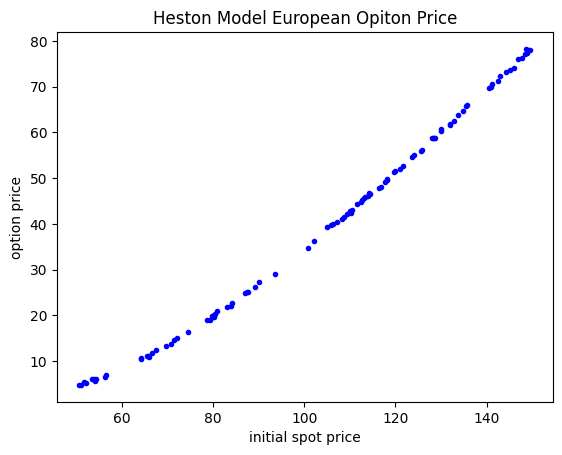

In [92]:
plt.title("Heston Model European Opiton Price")
plt.plot(hset.initial_spot_prices, prices, 'b.')
plt.xlabel("initial spot price")
plt.ylabel("option price")
plt.show()

/tmp/ipykernel_372/1860905182.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


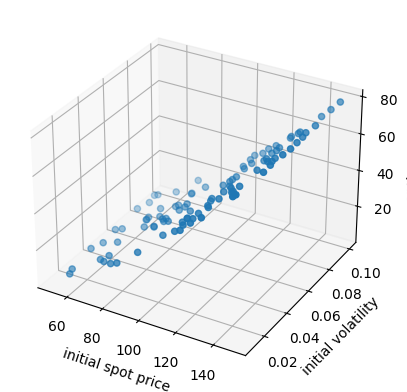

In [8]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(hset.initial_spot_prices, hset.initial_vols, prices, linewidth=0.2)
ax.scatter(hset.initial_spot_prices, hset.initial_vols, prices)

ax.set_xlabel("initial spot price")
ax.set_ylabel("initial volatility")
ax.set_zlabel("option price")
fig.show()

(1000, 100, 2)
(1000, 100)
spot_draws  (1000, 100)
Traced<ShapedArray(float64[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float64[1000])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0
(1000, 100)
[[ 21.29299089 318.289849    16.7012547  ... 146.08390438   0.
    0.        ]
 [243.46458269 131.04076049   6.9113556  ...  28.32562438 253.33490675
    0.        ]
 [  0.         120.70232263 101.01219475 ...  16.84827503   0.
    0.        ]
 ...
 [  0.          85.93845297   0.         ...  78.53352728 123.42978575
   15.52003103]
 [129.99935355 109.92830443  27.34461678 ...   0.           0.
    0.        ]
 [ 69.64610877   9.27372199  27.09650837 ... 108.99927263  84.00294824
  137.79480214]]


/tmp/ipykernel_372/2749131945.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


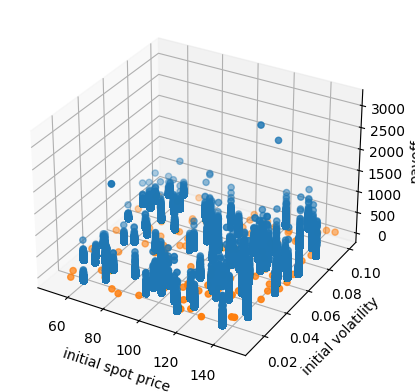

In [10]:
key, subkey = jrandom.split(key)
spot_range = Range(50.0, 150.0)
vol_range = Range(0.01, 0.1)
n_states = 100
h = HestonSoA(key=subkey, n_states=n_states, spot_range=spot_range, vol_range=vol_range)

h_payoff = jit(vmap(h.payoff))
key, subkey = jrandom.split(key)
keys = jrandom.split(subkey, num=1000)
payoffs = h_payoff(keys)
print(payoffs.shape)
print(payoffs)

init_spots = h.initial_spot_prices
init_spots = jnp.broadcast_to(init_spots, payoffs.shape)

init_vols = h.initial_vols
init_vols = jnp.broadcast_to(init_vols, payoffs.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(hset.initial_spot_prices, hset.initial_vols, prices, linewidth=0.2)
ax.scatter(init_spots, init_vols, payoffs)
ax.scatter(hset.initial_spot_prices, hset.initial_vols, prices)

ax.set_xlabel("initial spot price")
ax.set_ylabel("initial volatility")
ax.set_zlabel("payoff")
fig.show()

# plot one state configuration with many path sims
# plt.plot(payoffs[:, 0])
# key, subkey = jrandom.split(key)
# prices = price(subkey, hset)
# jax.debug.print("prices {}", prices)

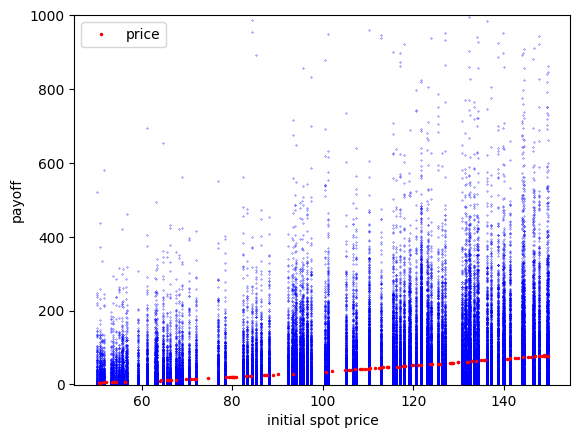

In [11]:

plt.plot(init_spots, payoffs, 'b.', markersize=0.5)
plt.plot(hset.initial_spot_prices, prices, 'r.', markersize=3, label='price')
plt.legend()
plt.xlabel('initial spot price')
plt.ylabel('payoff')
plt.ylim(-1, 1000)
plt.show()


In [103]:

# class HestonState
# class MarkovState
# dataclass

class Heston(eqx.Module):

    # S0: float = 100.0       # Initial spot price
    # K: float = 100.0        # Strike price
    # r: float = 0.0319       # Risk-free rate
    # v0: float = 0.010201    # Initial volatility
    # T: float = 1.00         # One year until expiry
    # rho: float = -0.7       # Correlation of asset and volatility
    # kappa: float = 6.21     # Mean-reversion rate
    # theta: float = 0.019    # Long run average volatility
    # xi: float = 0.61        # Volatility of volatility

    S0: float = 100.0       # Initial spot price
    K: float = 100.0        # Strike price
    r: float = 0.05         # Risk-free rate
    v0: float = 0.09        # Initial volatility
    T: float = 5.00         # n years until expiry, i.e. T2 - T1
    rho: float = -0.3       # Correlation of asset and volatility
    kappa: float = 2.00     # Mean-reversion rate
    theta: float = 0.09     # Long run average volatility
    xi: float = 1.00        # Volatility of volatility

    # def spot_path_lsm(self):
    #     # vols

    #     # vol_path = jnp.zeros_like(vol_draws)
    #     # vol_path = vol_path.at[0].set(self.v0)

    #     v0 = self.v0
    #     v_truncated = jnp.maximum(0.0, v0)
    #     v1 = v0 + self.kappa * T * (self.theta - v_truncated) + self.xi * jnp.sqrt(v_truncated * T) * vol_draws[i-1]

    #         v_truncated = jnp.maximum(0.0, vol_path[i-1])
    #         prev_path_contribution = vol_path[i-1] + self.kappa * dt * (self.theta - v_truncated)
    #         randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draws[i-1]
    #         vol_path = vol_path.at[i].set(prev_path_contribution + randomness)

    #     return vol_path


    #     vec_size = len(spot_draws)
    #     dt = self.T / vec_size
    #     spot_paths = jnp.zeros_like(vol_path)
    #     spot_paths = spot_paths.at[0].set(self.S0)

    #     for i in range(1, vec_size):
    #         v_truncated = jnp.maximum(0.0, vol_path[i-1])
    #         path_new_spot = spot_paths[i-1] * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draws[i-1])
    #         spot_paths = spot_paths.at[i].set(path_new_spot)
    #     return spot_paths

    # TODO: store vol_path inside class?
    def spot_path_for_loop(self, spot_draws: Array, vol_path: Array) -> Array:
        vec_size = len(spot_draws)
        dt = self.T / vec_size
        spot_paths = jnp.zeros_like(vol_path)
        spot_paths = spot_paths.at[0].set(self.S0)


        for i in range(1, vec_size):
            v_truncated = jnp.maximum(0.0, vol_path[i-1])
            path_new_spot = spot_paths[i-1] * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draws[i-1])
            spot_paths = spot_paths.at[i].set(path_new_spot)
        return spot_paths

    def spot_path(self, spot_draws: Array, vol_path: Array) -> Array:
        n_iter = len(spot_draws)
        dt = self.T / n_iter

        def spot_path_iter(prev_spot_path, iter_pair):
            spot_draw = iter_pair[0]
            vol = iter_pair[1]
            v_truncated = jnp.maximum(0.0, vol)
            path_new_spot = prev_spot_path * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draw)
            return path_new_spot, path_new_spot

        iter_values = jnp.column_stack((spot_draws, vol_path))
        carry, spot_paths = jax.lax.scan(spot_path_iter, jnp.array(self.S0), iter_values, length=n_iter)

        spot_paths = jnp.roll(spot_paths.at[-1].set(self.S0), 1)
        return spot_paths

    def volatility_path_for_loop(self, vol_draws: Float[Array, "n ..."]) -> Float[Array, "n ..."]:
        vec_size = len(vol_draws)
        dt = self.T / vec_size

        vol_path = jnp.zeros_like(vol_draws)
        vol_path = vol_path.at[0].set(self.v0)

        for i in range(1, vec_size):
            v_truncated = jnp.maximum(0.0, vol_path[i-1])
            prev_path_contribution = vol_path[i-1] + self.kappa * dt * (self.theta - v_truncated)
            randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draws[i-1]
            vol_path = vol_path.at[i].set(prev_path_contribution + randomness)

        return vol_path

    def volatility_path(self, vol_draws):
        n_iter = len(vol_draws)
        dt = self.T / n_iter

        def vol_path_iter(prev_vol_path, vol_draw):
            v_truncated = jnp.maximum(0.0, prev_vol_path)
            prev_path_contribution = prev_vol_path + self.kappa * dt * (self.theta - v_truncated)
            randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draw
            current = prev_path_contribution + randomness
            return current, current # use current both for carry and for y

        carry, vol_path = jax.lax.scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_iter)

        # we now have iteration 1 at position 0. Place initial v0 at the end and rotate into initial slot
        vol_path = jnp.roll(vol_path.at[-1].set(self.v0), 1)
        return vol_path

    def path(self, key: PRNGKeyArray, n_intervals: int = 1000):
        mean = jnp.zeros(2)
        cov = jnp.array([[1.0, self.rho], [self.rho, 1.0]])

        correlated_samples = jrandom.multivariate_normal(key, mean, cov, shape=(n_intervals,))

        vol_draws = correlated_samples[:, 0]
        spot_draws = correlated_samples[:, 1]

        vol_path = self.volatility_path(vol_draws)
        spot_path = self.spot_path(spot_draws, vol_path)
        return vol_path, spot_path

    def payoff(self, key: PRNGKeyArray, n_intervals: int = 1000, payoff_fn = EuropeanPayoff.call):
        _, spot_path = self.path(key, n_intervals)
        spot_maturity = spot_path[-1]
        payoff = payoff_fn(spot_maturity, self.K)
        return payoff
        
    def payoff_and_d(self, key: PRNGKeyArray, n_intervals: int = 1000, payoff_fn = EuropeanPayoff.call):
        vol_path, spot_path = self.path(key, n_intervals)
        spot_maturity = spot_path[-1]
        payoff = payoff_fn(spot_maturity, self.K)
        return payoff


class ModelState(eqx.Module):
    S0: float
    v0: float

def payoff(self, spot_path, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[-1]
    payoff = payoff_fn(spot_maturity, self.K)
    return payoff

def volatility_path(v0, vol_draws, self):
    n_iter = len(vol_draws)
    dt = self.T / n_iter

    def vol_path_iter(prev_vol_path, vol_draw):
        v_truncated = jnp.maximum(0.0, prev_vol_path)
        prev_path_contribution = prev_vol_path + self.kappa * dt * (self.theta - v_truncated)
        randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draw
        current = prev_path_contribution + randomness
        return current, current # use current both for carry and for y

    carry, vol_path = jax.lax.scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_iter)

    # we now have iteration 1 at position 0. Place initial v0 at the end and rotate into initial slot
    vol_path = jnp.roll(vol_path.at[-1].set(v0), 1)
    return vol_path


def spot_path(S0, self, spot_draws: Array, vol_path: Array) -> Array:
    n_iter = len(spot_draws)
    dt = self.T / n_iter

    def spot_path_iter(prev_spot_path, iter_pair):
        spot_draw = iter_pair[0]
        vol = iter_pair[1]
        v_truncated = jnp.maximum(0.0, vol)
        path_new_spot = prev_spot_path * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draw)
        return path_new_spot, path_new_spot

    iter_values = jnp.column_stack((spot_draws, vol_path))
    carry, spot_paths = jax.lax.scan(spot_path_iter, jnp.array(S0), iter_values, length=n_iter)

    spot_paths = jnp.roll(spot_paths.at[-1].set(S0), 1)
    return spot_paths


def path_and_payoff(state: ModelState, self, vol_draws, spot_draws):
    vol_path = volatility_path(state.v0, vol_draws, self)
    s_path = spot_path(state.S0, self, spot_draws, vol_path)
    
    jax.debug.print("spot initial: {}", s_path[0])
    jax.debug.print("spot maturity: {}", s_path[-1])

    
    jax.debug.print("vol initial: {}", vol_path[0])
    jax.debug.print("vol end: {}", vol_path[-1])

    p = payoff(self, s_path)
    return p
    
def path_initial(self, key: PRNGKeyArray, n_intervals: int = 1000):
    mean = jnp.zeros(2)
    cov = jnp.array([[1.0, self.rho], [self.rho, 1.0]])

    correlated_samples = jrandom.multivariate_normal(key, mean, cov, shape=(n_intervals,))

    vol_draws = correlated_samples[:, 0]
    spot_draws = correlated_samples[:, 1]

    p, dp = jax.value_and_grad(path_and_payoff)(ModelState(self.S0, self.v0), self, vol_draws, spot_draws)
    jax.debug.print("dp is {} {}", dp.v0, dp.S0)
    
    return p, dp

In [105]:
key = jrandom.PRNGKey(4)
heston = Heston()
path_initial(heston, key)

spot initial: 100.0
spot maturity: 172.1496809096212
vol initial: 0.09
vol end: 0.7641136467791223
dp is 5.453201300377142 1.7214968090962144


(Array(72.14968091, dtype=float64), ModelState(S0=f64[], v0=f64[]))

# Exploration

In [51]:
n_sims : int = 1000000
n_intervals: int = 1000
heston = Heston()

In [52]:
key = jrandom.PRNGKey(0)

key, subkey = jrandom.split(key)
vol_draws = jrandom.normal(key=subkey, shape=(100, ))
# print(vol_draws)

vol_path_for = heston.volatility_path_for_loop(vol_draws)
vol_path = heston.volatility_path(vol_draws)
assert(jnp.allclose(vol_path_for, vol_path))

In [53]:
key, subkey = jrandom.split(key)
spot_draws = jrandom.normal(key=subkey, shape=(100, ))

spot_path_for = heston.spot_path_for_loop(spot_draws, vol_path)
spot_path = heston.spot_path(spot_draws, vol_path)
assert(jnp.allclose(spot_path_for, spot_path))

In [90]:
key, subkey = jrandom.split(key)

mean = jnp.zeros(2)
cov = jnp.array([[1, heston.rho], [heston.rho, 1]])

print(cov)
correlated_samples = jrandom.multivariate_normal(key, mean, cov, shape=(100000,))
correlated_samples.shape

[[ 1.  -0.3]
 [-0.3  1. ]]


(100000, 2)

In [91]:
sample_mean = jnp.mean(correlated_samples, axis=0)
assert(jnp.allclose(sample_mean, mean, atol=1e-2))

In [92]:
sample_cov = jnp.cov(correlated_samples.T)
assert(jnp.allclose(sample_cov, cov, atol=1e-2))

In [93]:
jnp.corrcoef(correlated_samples.T)[0, 1]

Array(-0.30700636, dtype=float64)

In [94]:
jnp.corrcoef(correlated_samples[:, 0], correlated_samples[:, 1])

Array([[ 1.        , -0.30700636],
       [-0.30700636,  1.        ]], dtype=float64)

In [95]:
mean = jnp.zeros(2)
cov = jnp.array([[1, heston.rho], [heston.rho, 1]])

print(cov)

[[ 1.  -0.3]
 [-0.3  1. ]]


# Price

In [13]:
# Price calculation of heston model on european call option
def price(key):
    n_multiplier = 1
    n_simulations = 1000000 * n_multiplier
    n_outside_iter = 10 * n_multiplier
    n_sims_per_iter = n_simulations // n_outside_iter
    payoff_sum: float = 0.0
    key, subkey = jrandom.split(key)

    def pathwise_payoff_fn(payoff_sum, key):
        keys = jrandom.split(key, num=n_sims_per_iter)
        pathwise_payoff = vmap(heston.payoff)(keys)

        payoff_sum_iter = jnp.sum(pathwise_payoff)
        payoff_sum += payoff_sum_iter
        return payoff_sum, payoff_sum_iter

    keys = jrandom.split(subkey, num=n_outside_iter)
    payoff_sum, _ = jax.lax.scan(pathwise_payoff_fn, 0.0, keys, length=n_outside_iter)

    price = (payoff_sum / n_simulations) * jnp.exp(-heston.r * heston.T)
    jax.debug.print("price {}", price)


In [14]:
key = jrandom.PRNGKey(0)
heston = Heston()

In [15]:
price_fn = jit(price)

In [ ]:
%timeit price_fn(key)

price 34.93229832368327
price 34.93229832368327
price 34.93229832368327
price 34.93229832368327
price 34.93229832368327
price 34.93229832368327
price 34.93229832368327
price 34.93229832368327
8.99 s ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
price_fn(key)

price 34.93229832368327


# Different initial States

In [19]:
# heston_factory = lambda params: Heston(S0=params[0], v0=params[1])

def heston_factory(params):
  return Heston(S0=params[0], v0=params[1])

key, subkey = jrandom.split(key)
random_initial_spots = jrandom.uniform(key, shape=(100,), minval=50, maxval=150)
random_initial_vols = jrandom.uniform(key, shape=(100,), minval=0.01, maxval=0.1)
params = jnp.column_stack((random_initial_spots, random_initial_vols))

# params = zip(jnp.ones(100), jnp.ones(100))
# params = jnp.ones(shape=(100, 2))
# print(params.shape)
# hes = heston_factory(50, 0.09)
# hes = vmap(heston_factory)(random_initial_spots, random_initial_vols)

hes = [heston_factory(ps) for ps in params]
#print(hes)
# print(hes[1])
# print(hes.shape)
# initial_model_states =

# Visualize Data

In [18]:
n_sims : int = 10000
n_intervals: int = 1000
heston = Heston()
heston.S0 = 150

FrozenInstanceError: cannot assign to field 'S0'

In [68]:
heston_payoff_fn = jit(vmap(heston.payoff))

In [69]:
key, subkey = jrandom.split(key)
keys = jrandom.split(key, num=n_sims)

payoffs = heston_payoff_fn(keys)
print(payoffs.shape)
print(payoffs)

(10000,)
[112.45826534 145.11717678 119.75498397 ...  39.00841261   0.
   0.        ]


In [57]:
heston_paths_fn = jit(vmap(heston.path))

In [58]:
key, subkey = jrandom.split(key)
keys = jrandom.split(key, num=n_sims)
vol_paths, spot_paths = heston_paths_fn(keys)


print(spot_paths[..., -1].shape)
print(spot_paths.shape)
print(spot_paths)
pathwise_payoff = EuropeanPayoff.payoff(spot_paths, heston.K)

print(pathwise_payoff)
print(pathwise_payoff.shape)


(10000,)
(10000, 1000)
[[150.         149.85831638 153.22912623 ...  60.41005565  61.33104319
   59.78024655]
 [150.         152.383271   155.8651444  ... 440.98795614 450.03061919
  453.41677085]
 [150.         149.61379331 150.99725368 ...  23.73788578  23.33855944
   23.84407058]
 ...
 [150.         149.29709691 150.83942968 ...  60.25295097  60.0998801
   60.26146953]
 [150.         154.55633329 156.44737144 ... 400.14274201 399.86755058
  401.32089951]
 [150.         148.98407531 149.18099084 ...  88.71331659  88.73549769
   88.75768434]]
[  0.         353.41677085   0.         ...   0.         301.32089951
   0.        ]
(10000,)


In [59]:
# TODO: generate payoff samples for a bunch of other starting spots. Those spots
#       can either be found via MC or using some grid...
#
#       look into page 19 training inputs

In [60]:
print(spot_paths[:, 0])

[150. 150. 150. ... 150. 150. 150.]


In [61]:
print(jnp.sum(pathwise_payoff == 0.))

2268


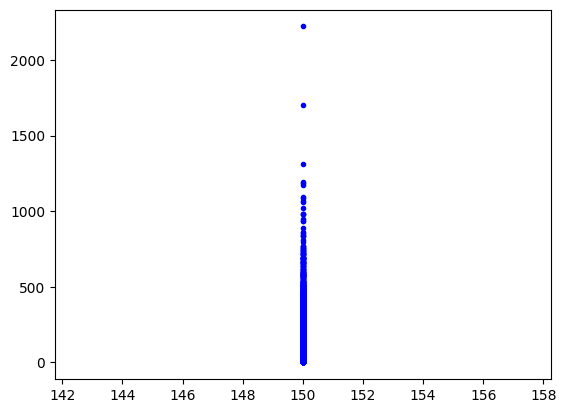

In [62]:
plt.plot(spot_paths[:, 0], pathwise_payoff, "b.")